<a href="https://colab.research.google.com/github/fxrdhan/Machine-Learning-Project/blob/main/Kelompok1_OccupancyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Occupancy Detection Classification menggunakan K-Nearest Neighbors dan Naive Bayes**


**Kelompok:** 1

| **NIM** | **Nama Anggota** |
|---|---|
| 101032300131 | Firdaus Arif Ramadhani |
| 101032300150 | Muhammad Fakhri Arrasyid |
| 101032300119 | Yoga Reswara |

## Deskripsi Project

Project ini bertujuan untuk mengklasifikasikan status okupansi ruangan (occupied/not occupied) berdasarkan data sensor lingkungan menggunakan algoritma **K-Nearest Neighbors (KNN)** dan **Naive Bayes**.

**Dataset:** UCI Occupancy Detection Dataset (Candanedo & Feldheim, 2016)
- 20,560 sampel
- 5 fitur: Temperature, Humidity, Light, CO2, Humidity Ratio
- Target: Binary Classification (0 = Not Occupied, 1 = Occupied)

**Referensi Utama:**
- Candanedo, L.M. & Feldheim, V. (2016). *Energy and Buildings*, 112, 28-39.
- Alam, M.S. et al. (2023). *MDPI Engineering Proceedings*, 58(1), 67.

## Ruang Lingkup Analisis

Penelitian ini memiliki 4 fokus analisis:

1. **Analisis Variasi Nilai k pada KNN** - Menguji pengaruh nilai k (1, 3, 5, 7, ..., 21) terhadap performa model
2. **Perbandingan Varian Naive Bayes** - Membandingkan Gaussian NB vs Bernoulli NB
3. **Feature Importance Analysis** - Mengidentifikasi sensor mana yang paling berpengaruh terhadap prediksi
4. **Trade-off Akurasi vs Waktu Komputasi** - Membandingkan efisiensi kedua algoritma

# **1. Setup dan Installation**

## 1.1. Install library (ucimlrepo)

In [1]:
!pip install ucimlrepo -q

## 1.2. Import semua library

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# Utilities
import time
import warnings

# Dataset
from ucimlrepo import fetch_ucirepo

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.2.2
NumPy version: 2.0.2


## 1.3. Settings (random seed, display options, ignore warnings)

In [3]:
# Random seed untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Ignore warnings
warnings.filterwarnings('ignore')

# Dictionary untuk menyimpan semua hasil eksperimen
results = {
    'baseline': {},
    'knn_tuning': {},
    'nb_tuning': {},
    'feature_importance': {},
    'cross_validation': {},
    'time_analysis': {}
}

print(f"Random State: {RANDOM_STATE}")

Random State: 42


# **2. Data Loading**

## **2.1. Info Dataset**

Unduh dataset Occupancy Detection dari UCI Machine Learning Repository menggunakan library `ucimlrepo`.

**Dataset Info:**
- ID: 357
- Nama: Occupancy Detection
- Sumber: Candanedo & Feldheim (2016)
- Link: https://archive.ics.uci.edu/dataset/357/occupancy+detection

## 2.2 Download UCI Dataset

In [4]:
occupancy_detection = fetch_ucirepo(id=357)

## 2.3. Metadata Dataset

In [5]:
# Ambil metadata
metadata = occupancy_detection.metadata
variables = occupancy_detection.variables

print(f"\nNama Dataset: {getattr(metadata, 'name', 'N/A')}")
print(f"UCI ID: {getattr(metadata, 'uci_id', 'N/A')}")

print(f"\n--- Informasi Umum ---")
print(f"Jumlah Instances: {getattr(metadata, 'num_instances', 'N/A')}")
print(f"Jumlah Features: {getattr(metadata, 'num_features', 'N/A')}")

print(f"\n--- Tipe Task ---")
print(f"Task: {getattr(metadata, 'task', 'N/A')}")
print(f"Area: {getattr(metadata, 'area', 'N/A')}")

print(f"\n--- Variabel ---")
for idx, row in variables.iterrows():
    print(f"  - {row['name']}: {row['type']} ({row['role']})")


Nama Dataset: Occupancy Detection 
UCI ID: 357

--- Informasi Umum ---
Jumlah Instances: 20560
Jumlah Features: 6

--- Tipe Task ---
Task: None
Area: Computer Science

--- Variabel ---
  - id: Integer (ID)
  - date: Date (Feature)
  - Temperature: Integer (Feature)
  - Humidity: Continuous (Feature)
  - Light: Integer (Feature)
  - CO2: Continuous (Feature)
  - HumidityRatio: Continuous (Feature)
  - Occupancy: Binary (Target)


## 2.4. Buat DataFrame

In [6]:
# Ambil features dan target
X = occupancy_detection.data.features
y = occupancy_detection.data.targets

# Gabung menjadi satu DataFrame untuk EDA
df = pd.concat([X, y], axis=1)

# Tampilkan nama kolom
print("Kolom Features (X):")
print(list(X.columns))

print("\nKolom Target (y):")
print(list(y.columns))

print("\nKolom DataFrame Gabungan:")
print(list(df.columns))

Kolom Features (X):
['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

Kolom Target (y):
['Occupancy']

Kolom DataFrame Gabungan:
['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']


## 2.5. Cek Shape dan Info Dasar


In [7]:
print(f"\n--- Shape ---")
print(f"Features (X): {X.shape} -> {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target (y): {y.shape} -> {y.shape[0]} samples")
print(f"DataFrame: {df.shape}")

print(f"\n--- Memory Usage ---")
print(f"Features: {X.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Target: {y.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Total: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

print(f"\n--- Preview Data (5 baris pertama) ---")
df.head()


--- Shape ---
Features (X): (20562, 6) -> 20562 samples, 6 features
Target (y): (20562, 1) -> 20562 samples
DataFrame: (20562, 7)

--- Memory Usage ---
Features: 7046.29 KB
Target: 160.77 KB
Total: 7206.93 KB

--- Preview Data (5 baris pertama) ---


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529,1.0000
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065,1.0000
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199,1.0000
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175,1.0000
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518,1.0000


# **3. Exploratory Data Analysis (EDA)**

## 3.1. Overview


Lihat struktur dan karakteristik dasar dari dataset.

### 3.1.1. n Baris Pertama dan Terakhir DataFrame

In [8]:
display(df.head())

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529,1.0000
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065,1.0000
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199,1.0000
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175,1.0000
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518,1.0000


In [9]:
display(df.tail())

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
20557,2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.00421296819328694,1.0000
20558,2015-02-18 09:16:00,20.865,27.745,423.5,1514.5,0.00423026193160229,1.0000
20559,2015-02-18 09:16:59,20.89,27.745,423.5,1521.5,0.00423681810140671,1.0000
20560,2015-02-18 09:17:59,20.89,28.0225,418.75,1632,0.0042794854718673,1.0000
20561,2015-02-18 09:19:00,21,28.1,409,1864,0.00432073200293677,1.0000


### 3.1.2. Info DataFrame

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20562 entries, 0 to 20561
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20562 non-null  object 
 1   Temperature    20562 non-null  object 
 2   Humidity       20562 non-null  object 
 3   Light          20562 non-null  object 
 4   CO2            20562 non-null  object 
 5   HumidityRatio  20562 non-null  object 
 6   Occupancy      20560 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.1+ MB


### 3.1.3. Fix Data Types

In [11]:
print(df.dtypes)

date              object
Temperature       object
Humidity          object
Light             object
CO2               object
HumidityRatio     object
Occupancy        float64
dtype: object


In [12]:
# Konversi kolom numerik ke numeric
numeric_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Konversi Occupancy ke numeric (biarkan float dulu)
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')

In [13]:
# Missing values setelah konversi
print(f"\nMissing values setelah konversi:")
print(df.isnull().sum())



Missing values setelah konversi:
date             0
Temperature      2
Humidity         2
Light            2
CO2              2
HumidityRatio    2
Occupancy        2
dtype: int64


In [14]:
# Drop rows dengan NaN (jika ada)
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"\nRows sebelum dropna: {rows_before}")
print(f"Rows sesudah dropna: {rows_after}")
print(f"Rows dihapus: {rows_before - rows_after}")


Rows sebelum dropna: 20562
Rows sesudah dropna: 20560
Rows dihapus: 2


In [15]:
# Convert Occupancy ke int
df['Occupancy'] = df['Occupancy'].astype(int)

In [16]:
print(df.dtypes)

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object


### 3.1.4. Statistik Deskriptif

In [17]:
# Hanya untuk kolom numerik (exclude date)
numeric_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
df[numeric_cols + ['Occupancy']].describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.0000,20560.0000,20560.0000,20560.0000,20560.0000,20560.0000
mean,20.9062,27.6559,130.7566,690.5533,0.0042,0.2310
std,1.0553,4.9822,210.4309,311.2013,0.0008,0.4215
min,19.0000,16.7450,0.0000,412.7500,0.0027,0.0000
25%,20.2000,24.5000,0.0000,460.0000,0.0037,0.0000
50%,20.7000,27.2900,0.0000,565.4167,0.0043,0.0000
75%,21.5250,31.2900,301.0000,804.6667,0.0048,0.0000
max,24.4083,39.5000,1697.2500,2076.5000,0.0065,1.0000


## 3.2. Target Analysis

Menganalisis distribusi kelas target (Occupancy) untuk memahami proporsi data occupied vs not occupied.

### 3.2.1. Value Counts Target

In [18]:
target_counts = df['Occupancy'].value_counts()
target_pct = df['Occupancy'].value_counts(normalize=True) * 100

target_dist = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_pct.round(2)
})
target_dist.index = ['Not Occupied (0)', 'Occupied (1)']

print(target_dist)

                  Count  Percentage (%)
Not Occupied (0)  15810         76.9000
Occupied (1)       4750         23.1000


### 3.2.2. Visualisasi Distribusi Target

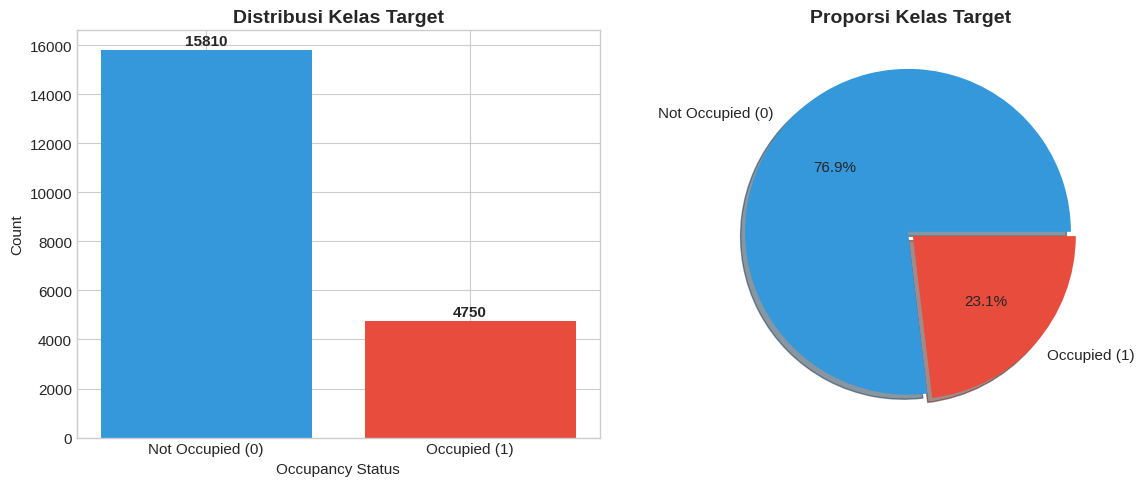

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar Chart
colors = ['#3498db', '#e74c3c']
target_counts = df['Occupancy'].value_counts()

axes[0].bar(['Not Occupied (0)', 'Occupied (1)'], target_counts.values, color=colors)
axes[0].set_title('Distribusi Kelas Target', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Occupancy Status')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# Pie Chart
axes[1].pie(target_counts.values,
            labels=['Not Occupied (0)', 'Occupied (1)'],
            autopct='%1.1f%%',
            colors=colors,
            explode=(0.02, 0.02),
            shadow=True)
axes[1].set_title('Proporsi Kelas Target', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.2.3. Class Imbalance Ratio

In [20]:
count_0 = (df['Occupancy'] == 0).sum()
count_1 = (df['Occupancy'] == 1).sum()

imbalance_ratio = count_0 / count_1

print(f"Not Occupied (0): {count_0}")
print(f"Occupied (1): {count_1}")
print(f"\nImbalance Ratio (0:1): {imbalance_ratio:.2f} : 1")

if imbalance_ratio > 1.5:
    print(f"\nStatus: Dataset IMBALANCED")
    print(f"Kelas mayoritas (Not Occupied) {imbalance_ratio:.2f}x lebih banyak dari kelas minoritas")
    print("Rekomendasi: Gunakan Stratified Split untuk menjaga proporsi kelas")
else:
    print(f"\nStatus: Dataset BALANCED")

Not Occupied (0): 15810
Occupied (1): 4750

Imbalance Ratio (0:1): 3.33 : 1

Status: Dataset IMBALANCED
Kelas mayoritas (Not Occupied) 3.33x lebih banyak dari kelas minoritas
Rekomendasi: Gunakan Stratified Split untuk menjaga proporsi kelas


## 3.3 Feature Distribution

Menganalisis distribusi setiap fitur untuk memahami karakteristik data dan mendeteksi outliers.

**Fitur yang dianalisis:**
1. Temperature (suhu ruangan)
2. Humidity (kelembaban relatif)
3. Light (intensitas cahaya)
4. CO2 (konsentrasi karbondioksida)
5. HumidityRatio (rasio kelembaban)

### 3.3.1. Histogram Semua Fitur

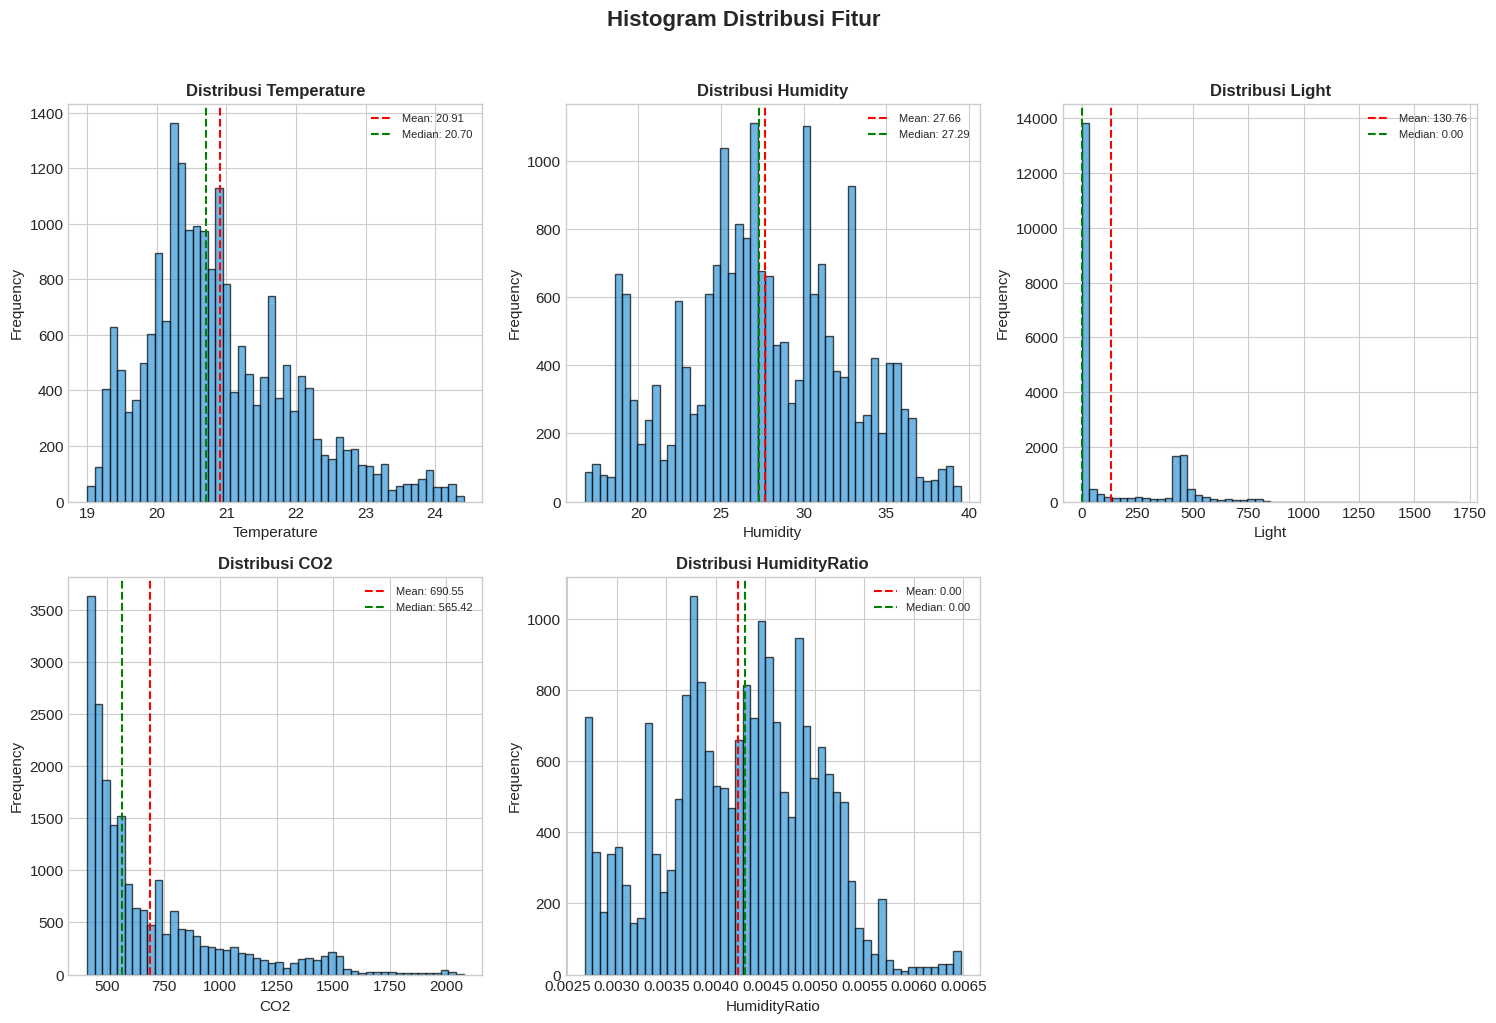

In [21]:
numeric_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribusi {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    axes[idx].axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.2f}')
    axes[idx].legend(fontsize=8)

# Hapus subplot kosong (index 5)
axes[5].axis('off')

plt.suptitle('Histogram Distribusi Fitur', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3.2. Boxplot Semua Fitur

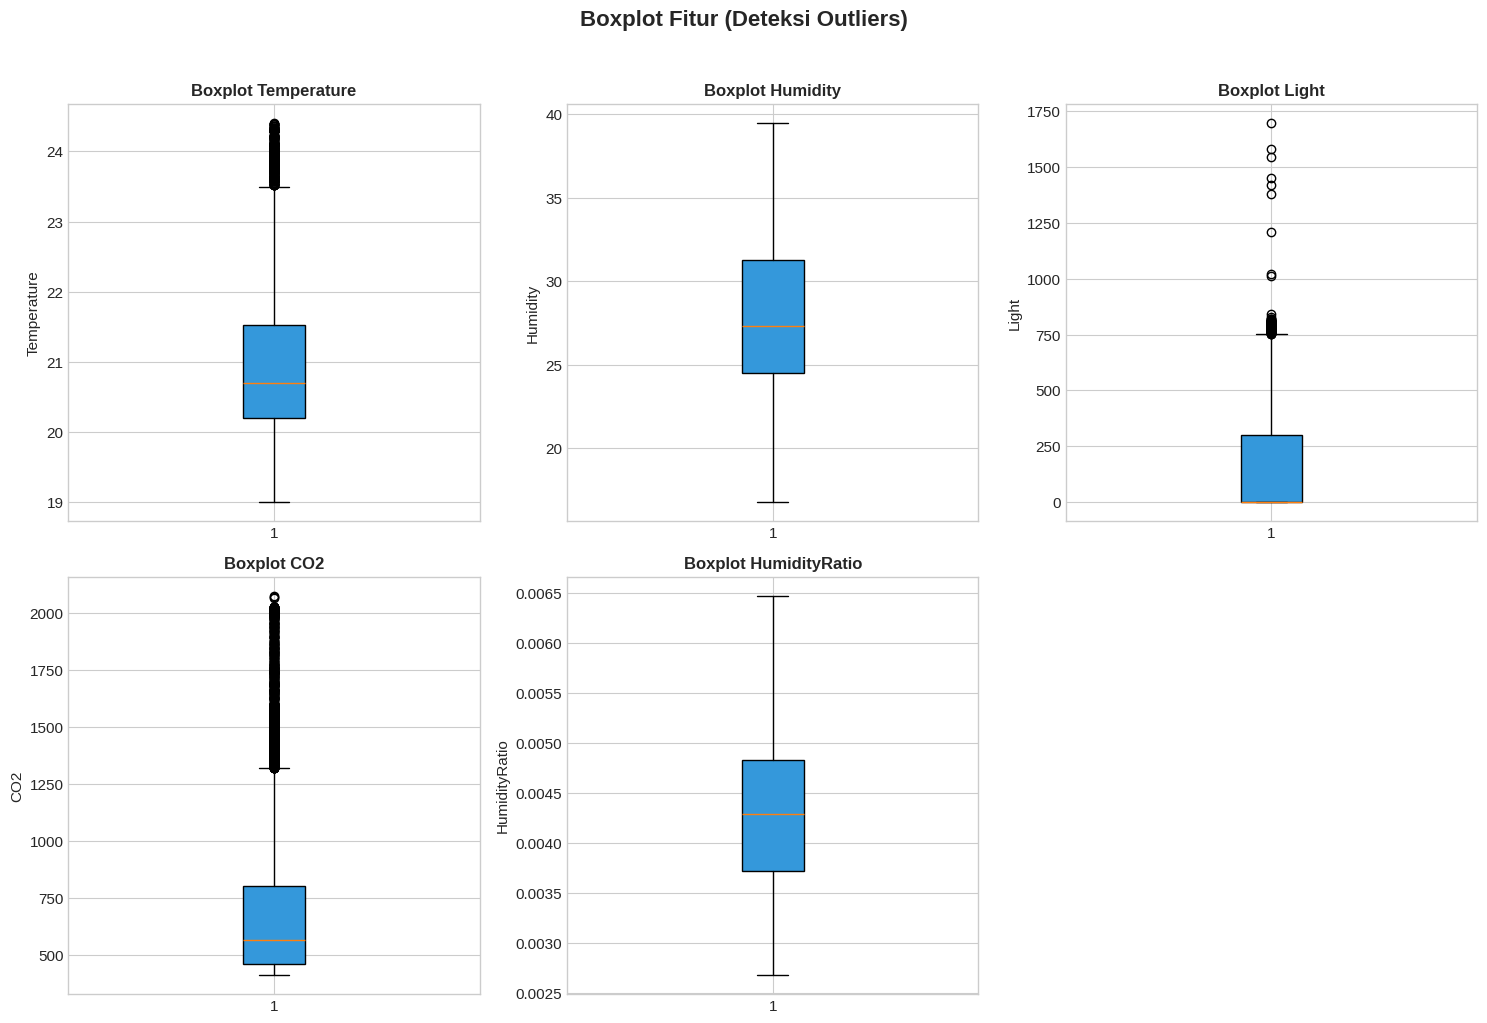

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    bp = axes[idx].boxplot(df[col], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    axes[idx].set_title(f'Boxplot {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)

# Hapus subplot kosong
axes[5].axis('off')

plt.suptitle('Boxplot Fitur (Deteksi Outliers)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3.3. Deteksi Outliers dengan IQR Method

In [23]:
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df) * 100)

    outlier_summary.append({
        'Feature': col,
        'Q1': round(Q1, 4),
        'Q3': round(Q3, 4),
        'IQR': round(IQR, 4),
        'Lower Bound': round(lower_bound, 4),
        'Upper Bound': round(upper_bound, 4),
        'Outlier Count': outlier_count,
        'Outlier %': round(outlier_pct, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

,Feature,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier %
0,Temperature,20.2000,21.5250,1.3250,18.2125,23.5125,519,2.5200
1,Humidity,24.5000,31.2900,6.7900,14.3150,41.4750,0,0.0000
2,Light,0.0000,301.0000,301.0000,-451.5000,752.5000,183,0.8900
3,CO2,460.0000,804.6667,344.6667,-57.0000,1321.6667,1449,7.0500
4,HumidityRatio,0.0037,0.0048,0.0011,0.0020,0.0065,0,0.0000


Catatan: Outliers TIDAK akan dihapus karena merepresentasikan kondisi nyata

(contoh: Light=0 saat malam hari, CO2 tinggi saat banyak orang)

## 3.4 Correlation Analysis

Menganalisis korelasi antar fitur dan korelasi fitur dengan target untuk mengidentifikasi fitur yang paling berpengaruh.

### 3.4.1. Correlation Matrix

In [24]:
# Buat correlation matrix (hanya numerik)
corr_cols = numeric_cols + ['Occupancy']
corr_matrix = df[corr_cols].corr()

print(corr_matrix.round(4))

               Temperature  Humidity   Light    CO2  HumidityRatio  Occupancy
Temperature         1.0000   -0.1570  0.6886 0.4500         0.2053     0.5556
Humidity           -0.1570    1.0000 -0.0295 0.2997         0.9327     0.0462
Light               0.6886   -0.0295  1.0000 0.4481         0.2233     0.9148
CO2                 0.4500    0.2997  0.4481 1.0000         0.4780     0.5016
HumidityRatio       0.2053    0.9327  0.2233 0.4780         1.0000     0.2573
Occupancy           0.5556    0.0462  0.9148 0.5016         0.2573     1.0000


### 3.4.2. Heatmap Correlation

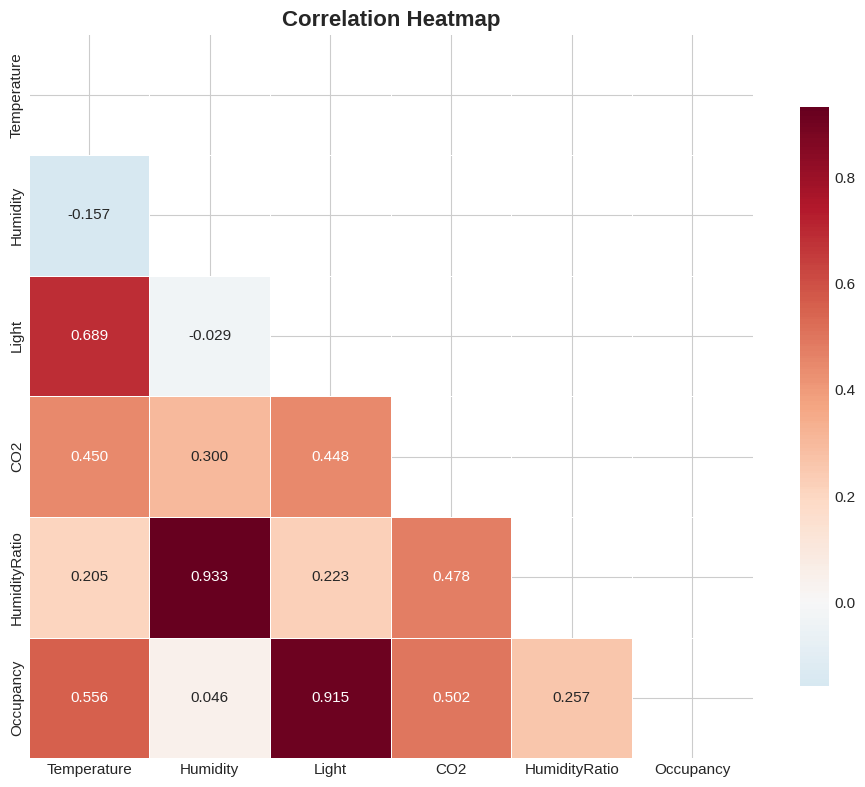

In [25]:
plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            center=0,
            mask=mask,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})

plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4.4. Korelasi Fitur dengan Target

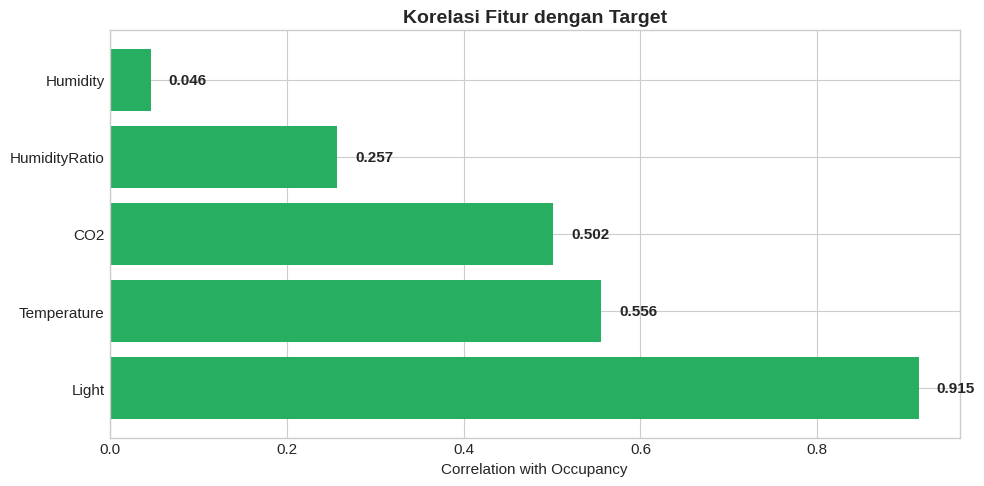


--- INSIGHT ---


In [26]:
# Hitung korelasi dengan target
corr_with_target = df[numeric_cols].corrwith(df['Occupancy']).sort_values(ascending=False)

corr_target_df = pd.DataFrame({
    'Feature': corr_with_target.index,
    'Correlation': corr_with_target.values,
    'Abs Correlation': abs(corr_with_target.values)
}).sort_values('Abs Correlation', ascending=False)

# Visualisasi
plt.figure(figsize=(10, 5))
colors = ['#27ae60' if x > 0 else '#e74c3c' for x in corr_with_target.values]
bars = plt.barh(corr_with_target.index, corr_with_target.values, color=colors)
plt.xlabel('Correlation with Occupancy')
plt.title('Korelasi Fitur dengan Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)

# Tambah label nilai
for bar, val in zip(bars, corr_with_target.values):
    plt.text(val + 0.02 if val > 0 else val - 0.08, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Insight
print("\n--- INSIGHT ---")
top_feature = corr_target_df.iloc[0]['Feature']
top_corr = corr_target_df.iloc[0]['Correlation']

### 3.4.4. Pairplot

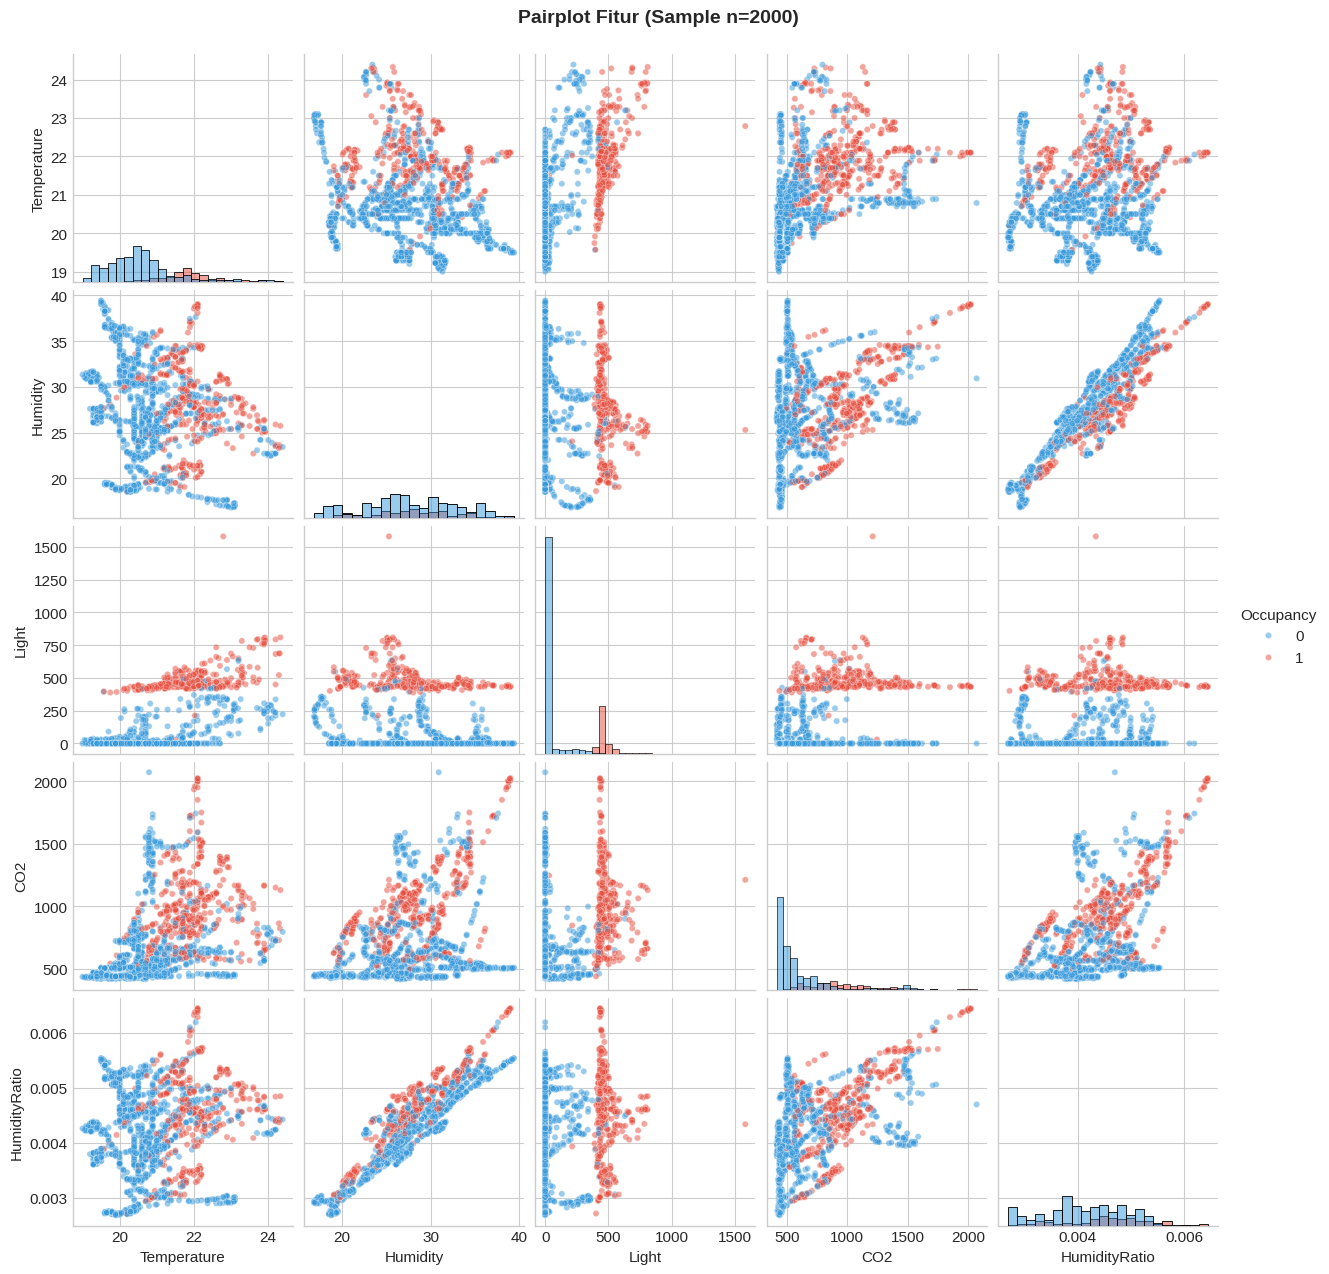

In [27]:
# Sample data untuk pairplot agar tidak terlalu lama
df_sample = df[numeric_cols + ['Occupancy']].sample(n=2000, random_state=RANDOM_STATE)

sns.pairplot(df_sample, hue='Occupancy', palette=['#3498db', '#e74c3c'],
             diag_kind='hist', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle('Pairplot Fitur (Sample n=2000)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 3.5. EDA Summary

**1. Data Overview:**
- Total samples: 20,560 (setelah drop 2 rows dengan NaN)
- Total features: 5 fitur numerik (Temperature, Humidity, Light, CO2, HumidityRatio)
- Kolom 'date' tidak digunakan untuk modeling
- Tidak ada missing values setelah preprocessing

**2. Target Distribution:**
- Not Occupied (0): 15,810 (76.9%)
- Occupied (1): 4,750 (23.1%)
- Dataset IMBALANCED dengan rasio 3.33 : 1
- Perlu menggunakan Stratified Split untuk menjaga proporsi

**3. Feature Distribution:**
- Light: Sangat skewed, banyak nilai 0 (lampu mati/malam hari), Mean=130.76, Median=0
- CO2: Skewed dengan outliers 7.05% (1,449 data), Mean=690.55, Median=565.42
- Temperature: Relatif normal, outliers 2.52% (519 data)
- Humidity: Normal, tidak ada outliers
- HumidityRatio: Normal, tidak ada outliers
- Outliers TIDAK dihapus karena merepresentasikan kondisi nyata

**4. Correlation dengan Target (Occupancy):**

| Fitur | Korelasi | Interpretasi |
|-------|----------|--------------|
| Light | 0.915 | Sangat Kuat (Positif) |
| Temperature | 0.556 | Sedang (Positif) |
| CO2 | 0.502 | Sedang (Positif) |
| HumidityRatio | 0.257 | Lemah (Positif) |
| Humidity | 0.046 | Sangat Lemah |

**5. Insight Utama:**
- **Light adalah fitur paling penting** dengan korelasi 0.915 (sesuai paper asli)
- Temperature dan CO2 juga cukup diskriminatif
- Humidity hampir tidak berpengaruh terhadap occupancy

# **4. Data Preprocessing**

Pada section ini kita akan:
1. Memisahkan features (X) dan target (y)
2. Split data menjadi training dan test set (80:20)
3. Melakukan feature scaling dengan StandardScaler

**Catatan:** Kolom 'date' tidak digunakan untuk modeling.

## 4.1. Pisahkan Features (X) dan Target (y)

In [28]:
# Fitur yang akan digunakan (exclude 'date')
feature_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [29]:
X = df[feature_cols].copy()
y = df['Occupancy'].copy()

In [30]:
print(f"Features: {feature_cols}")
print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")

Features: ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

Shape X: (20560, 5)
Shape y: (20560,)


In [31]:
display(X.head())

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.1800,27.2720,426.0000,721.2500,0.0048
1,23.1500,27.2675,429.5000,714.0000,0.0048
2,23.1500,27.2450,426.0000,713.5000,0.0048
3,23.1500,27.2000,426.0000,708.2500,0.0048
4,23.1000,27.2000,426.0000,704.5000,0.0048


In [32]:
display(y.head())

,Occupancy
0,1
1,1
2,1
3,1
4,1


## 4.2. Train-Test Split (Stratified)

In [33]:
# Split dengan stratify untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # Penting: menjaga proporsi kelas
)

In [34]:
print(f"Test Size: 20%")
print(f"Random State: {RANDOM_STATE}")
print(f"Stratified: Yes")

Test Size: 20%
Random State: 42
Stratified: Yes


In [35]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (16448, 5)
X_test: (4112, 5)
y_train: (16448,)
y_test: (4112,)


In [36]:
print(f"Total Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Total Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Total Training: 16448 (80.0%)
Total Test: 4112 (20.0%)


## 4.3. Cek Proporsi Kelas Setelah Split

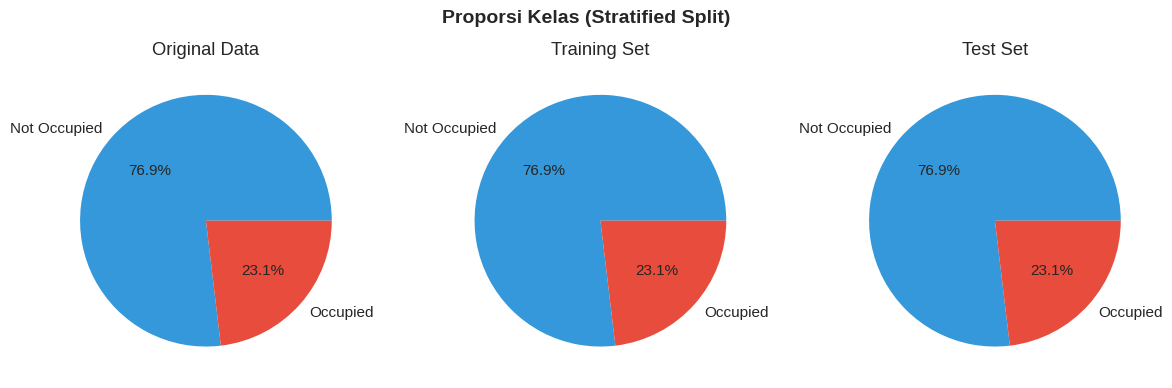

In [37]:
# Proporsi di training set
train_counts = y_train.value_counts()
train_pct = y_train.value_counts(normalize=True) * 100

# Proporsi di test set
test_counts = y_test.value_counts()
test_pct = y_test.value_counts(normalize=True) * 100

# Proporsi original
orig_pct = y.value_counts(normalize=True) * 100

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].pie(y.value_counts().values, labels=['Not Occupied', 'Occupied'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[0].set_title('Original Data')

axes[1].pie(y_train.value_counts().values, labels=['Not Occupied', 'Occupied'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[1].set_title('Training Set')

axes[2].pie(y_test.value_counts().values, labels=['Not Occupied', 'Occupied'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[2].set_title('Test Set')

plt.suptitle('Proporsi Kelas (Stratified Split)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.4. Feature Scaling (StandardScaler)

**Formula:**
$$z = \frac{x - \mu}{\sigma}$$

where:
- $x$ = original value
- $\mu$ = mean of the training data
- $\sigma$ = standard deviation of the training data
- $z$ = scaled value

**Process:**
- Fit on training data
- Transform on training and test data

In [38]:
scaler = StandardScaler()

# Fit on training data, transform on training and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

In [40]:
print(f"\nShape X_train_scaled: {X_train_scaled.shape}")
print(f"Shape X_test_scaled: {X_test_scaled.shape}")


Shape X_train_scaled: (16448, 5)
Shape X_test_scaled: (4112, 5)


## 4.5. Cek Hasil Scaling

In [41]:
# Buat DataFrame perbandingan
comparison_data = []

for col in feature_cols:
    comparison_data.append({
        'Feature': col,
        'Before Mean': X_train[col].mean(),
        'Before Std': X_train[col].std(),
        'Before Min': X_train[col].min(),
        'Before Max': X_train[col].max(),
        'After Mean': X_train_scaled[col].mean(),
        'After Std': X_train_scaled[col].std(),
        'After Min': X_train_scaled[col].min(),
        'After Max': X_train_scaled[col].max()
    })

comparison_df = pd.DataFrame(comparison_data)

In [42]:
display(comparison_df.round(4))

,Feature,Before Mean,Before Std,Before Min,Before Max,After Mean,After Std,After Min,After Max
0,Temperature,20.9042,1.0550,19.0000,24.4083,0.0000,1.0000,-1.8050,3.3215
1,Humidity,27.6550,4.9800,16.7900,39.5000,-0.0000,1.0000,-2.1818,2.3786
2,Light,130.6717,210.7280,0.0000,1697.2500,0.0000,1.0000,-0.6201,7.4344
3,CO2,691.0197,312.4068,413.0000,2076.5000,-0.0000,1.0000,-0.8900,4.4350
4,HumidityRatio,0.0042,0.0008,0.0027,0.0065,0.0000,1.0000,-2.0208,2.9239


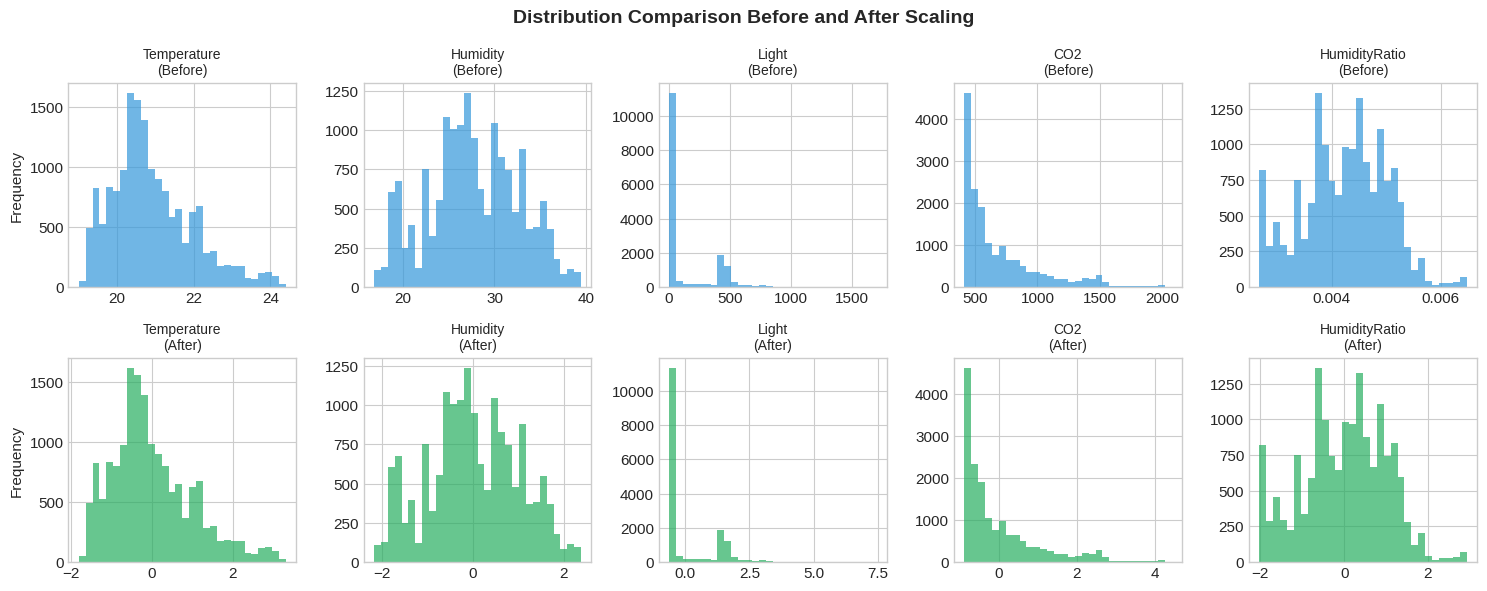

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, col in enumerate(feature_cols):
    # Sebelum scaling
    axes[0, idx].hist(X_train[col], bins=30, color='#3498db', alpha=0.7)
    axes[0, idx].set_title(f'{col}\n(Before)', fontsize=10)
    axes[0, idx].set_ylabel('Frequency' if idx == 0 else '')

    # Sesudah scaling
    axes[1, idx].hist(X_train_scaled[col], bins=30, color='#27ae60', alpha=0.7)
    axes[1, idx].set_title(f'{col}\n(After)', fontsize=10)
    axes[1, idx].set_ylabel('Frequency' if idx == 0 else '')

plt.suptitle('Distribution Comparison Before and After Scaling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [44]:
print(f"Mean setelah scaling: {X_train_scaled.mean().mean():.6f} (expected: ~0)")
print(f"Std setelah scaling: {X_train_scaled.std().mean():.6f} (expected: ~1)")

Mean setelah scaling: 0.000000 (expected: ~0)
Std setelah scaling: 1.000030 (expected: ~1)


## 4.6. Summary Data Preprocessing

In [45]:
print(f"""
--- Dataset Info ---
Original samples: {len(df)}
Features used: {feature_cols}
Target: Occupancy (Binary: 0/1)

--- Train-Test Split ---
Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)
Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)
Stratified: Yes

--- Feature Scaling ---
Method: StandardScaler
Fit on: Training data only
Transform on: Training and Test data

--- Variabel yang tersedia ---
X_train_scaled: Training features (scaled)
X_test_scaled: Test features (scaled)
y_train: Training target
y_test: Test target
""")

# Simpan info ke results dictionary
results['preprocessing'] = {
    'n_samples': len(df),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'features': feature_cols,
    'scaler': 'StandardScaler',
    'test_size': 0.2,
    'stratified': True
}


--- Dataset Info ---
Original samples: 20560
Features used: ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
Target: Occupancy (Binary: 0/1)

--- Train-Test Split ---
Training set: 16448 samples (80.0%)
Test set: 4112 samples (20.0%)
Stratified: Yes

--- Feature Scaling ---
Method: StandardScaler
Fit on: Training data only
Transform on: Training and Test data

--- Variabel yang tersedia ---
X_train_scaled: Training features (scaled)
X_test_scaled: Test features (scaled)
y_train: Training target
y_test: Test target



# **5. Baseline Model**

Buat baseline model untuk:
1. **KNN** dengan k=5 (default)
2. **Gaussian Naive Bayes**

Baseline ini akan menjadi referensi untuk hyperparameter tuning selanjutnya.

### 5.1. KNN Baseline

In [46]:
# Inisialisasi model
knn_baseline = KNeighborsClassifier(n_neighbors=5)

# Training + catat waktu
start_train = time.time()
knn_baseline.fit(X_train_scaled, y_train)
knn_train_time = time.time() - start_train

# Prediksi + catat waktu
start_pred = time.time()
y_pred_knn = knn_baseline.predict(X_test_scaled)
knn_pred_time = time.time() - start_pred

# Hitung metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f"\nParameter: k=5 (default)")
print(f"\n--- Waktu Komputasi ---")
print(f"Training Time: {knn_train_time:.4f} detik")
print(f"Prediction Time: {knn_pred_time:.4f} detik")

print(f"\n--- Metrics ---")
print(f"Accuracy:  {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall:    {knn_recall:.4f}")
print(f"F1-Score:  {knn_f1:.4f}")

print(f"\n--- Classification Report ---")
print(classification_report(y_test, y_pred_knn, target_names=['Not Occupied', 'Occupied']))


Parameter: k=5 (default)

--- Waktu Komputasi ---
Training Time: 0.0258 detik
Prediction Time: 0.0313 detik

--- Metrics ---
Accuracy:  0.9929 (99.29%)
Precision: 0.9802
Recall:    0.9895
F1-Score:  0.9848

--- Classification Report ---
              precision    recall  f1-score   support

Not Occupied       1.00      0.99      1.00      3162
    Occupied       0.98      0.99      0.98       950

    accuracy                           0.99      4112
   macro avg       0.99      0.99      0.99      4112
weighted avg       0.99      0.99      0.99      4112



### 5.2. KNN Confusion Matrix

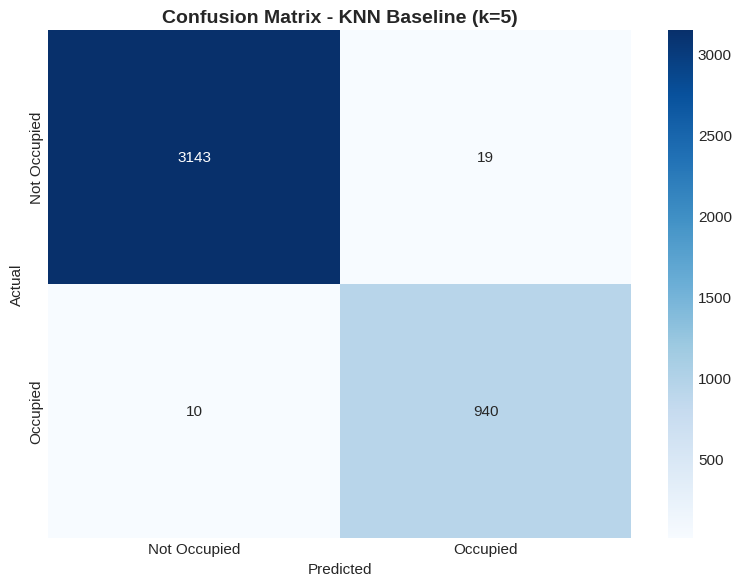

In [47]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Occupied', 'Occupied'],
            yticklabels=['Not Occupied', 'Occupied'])
plt.title('Confusion Matrix - KNN Baseline (k=5)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [48]:
# Detail confusion matrix
tn, fp, fn, tp = cm_knn.ravel()
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

True Negative (TN): 3143
False Positive (FP): 19
False Negative (FN): 10
True Positive (TP): 940


### 5.3. Gaussian Naive Bayes Baseline

In [49]:
# Inisialisasi model
gnb_baseline = GaussianNB()

# Training + catat waktu
start_train = time.time()
gnb_baseline.fit(X_train_scaled, y_train)
gnb_train_time = time.time() - start_train

# Prediksi + catat waktu
start_pred = time.time()
y_pred_gnb = gnb_baseline.predict(X_test_scaled)
gnb_pred_time = time.time() - start_pred

# Hitung metrics
gnb_accuracy = accuracy_score(y_test, y_pred_gnb)
gnb_precision = precision_score(y_test, y_pred_gnb)
gnb_recall = recall_score(y_test, y_pred_gnb)
gnb_f1 = f1_score(y_test, y_pred_gnb)

In [50]:
print(f"\nParameter: Default")
print(f"\n--- Waktu Komputasi ---")
print(f"Training Time: {gnb_train_time:.4f} detik")
print(f"Prediction Time: {gnb_pred_time:.4f} detik")


Parameter: Default

--- Waktu Komputasi ---
Training Time: 0.0088 detik
Prediction Time: 0.0029 detik


In [51]:
print(f"\n--- Metrics ---")
print(f"Accuracy:  {gnb_accuracy:.4f} ({gnb_accuracy*100:.2f}%)")
print(f"Precision: {gnb_precision:.4f}")
print(f"Recall:    {gnb_recall:.4f}")
print(f"F1-Score:  {gnb_f1:.4f}")


--- Metrics ---
Accuracy:  0.9652 (96.52%)
Precision: 0.8705
Recall:    0.9979
F1-Score:  0.9299


In [52]:
print(f"\n--- Classification Report ---")
print(classification_report(y_test, y_pred_gnb, target_names=['Not Occupied', 'Occupied']))


--- Classification Report ---
              precision    recall  f1-score   support

Not Occupied       1.00      0.96      0.98      3162
    Occupied       0.87      1.00      0.93       950

    accuracy                           0.97      4112
   macro avg       0.93      0.98      0.95      4112
weighted avg       0.97      0.97      0.97      4112



### 5.4. GNB Confusion Matrix

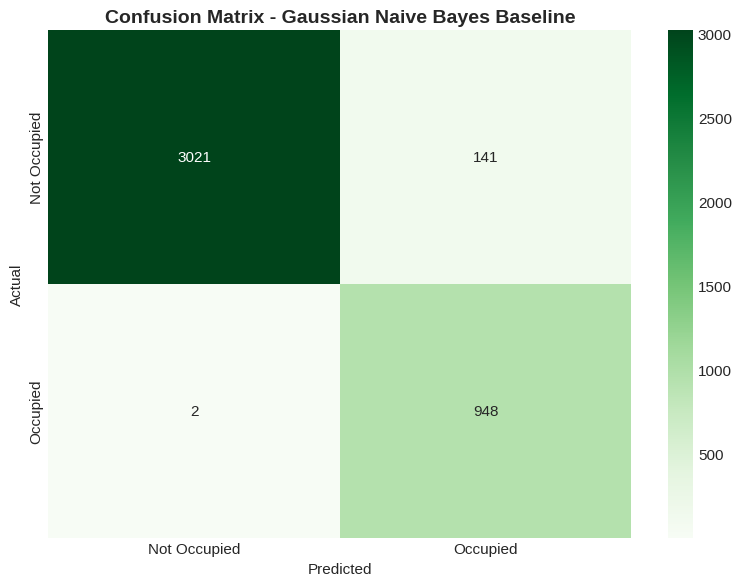

In [53]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Occupied', 'Occupied'],
            yticklabels=['Not Occupied', 'Occupied'])
plt.title('Confusion Matrix - Gaussian Naive Bayes Baseline', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [54]:
# Detail confusion matrix
tn, fp, fn, tp = cm_gnb.ravel()
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

True Negative (TN): 3021
False Positive (FP): 141
False Negative (FN): 2
True Positive (TP): 948


### 5.5. Baseline Comparison

In [55]:
# Buat DataFrame perbandingan
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Prediction Time (s)'],
    'KNN (k=5)': [knn_accuracy, knn_precision, knn_recall, knn_f1, knn_train_time, knn_pred_time],
    'Gaussian NB': [gnb_accuracy, gnb_precision, gnb_recall, gnb_f1, gnb_train_time, gnb_pred_time]
}

baseline_comparison = pd.DataFrame(comparison_data)
baseline_comparison['Difference'] = baseline_comparison['KNN (k=5)'] - baseline_comparison['Gaussian NB']
baseline_comparison['Winner'] = baseline_comparison.apply(
    lambda row: 'KNN' if row['Difference'] > 0 else ('GNB' if row['Difference'] < 0 else 'Tie'), axis=1
)

# Untuk waktu, winner adalah yang lebih cepat (nilai lebih kecil)
baseline_comparison.loc[baseline_comparison['Metric'].str.contains('Time'), 'Winner'] = \
    baseline_comparison.loc[baseline_comparison['Metric'].str.contains('Time')].apply(
        lambda row: 'GNB' if row['Difference'] > 0 else 'KNN', axis=1
    )

display(baseline_comparison.round(4))

,Metric,KNN (k=5),Gaussian NB,Difference,Winner
0,Accuracy,0.9929,0.9652,0.0277,KNN
1,Precision,0.9802,0.8705,0.1097,KNN
2,Recall,0.9895,0.9979,-0.0084,GNB
3,F1-Score,0.9848,0.9299,0.0549,KNN
4,Training Time (s),0.0258,0.0088,0.0170,GNB
5,Prediction Time (s),0.0313,0.0029,0.0284,GNB


### 5.6. Baseline Visualization

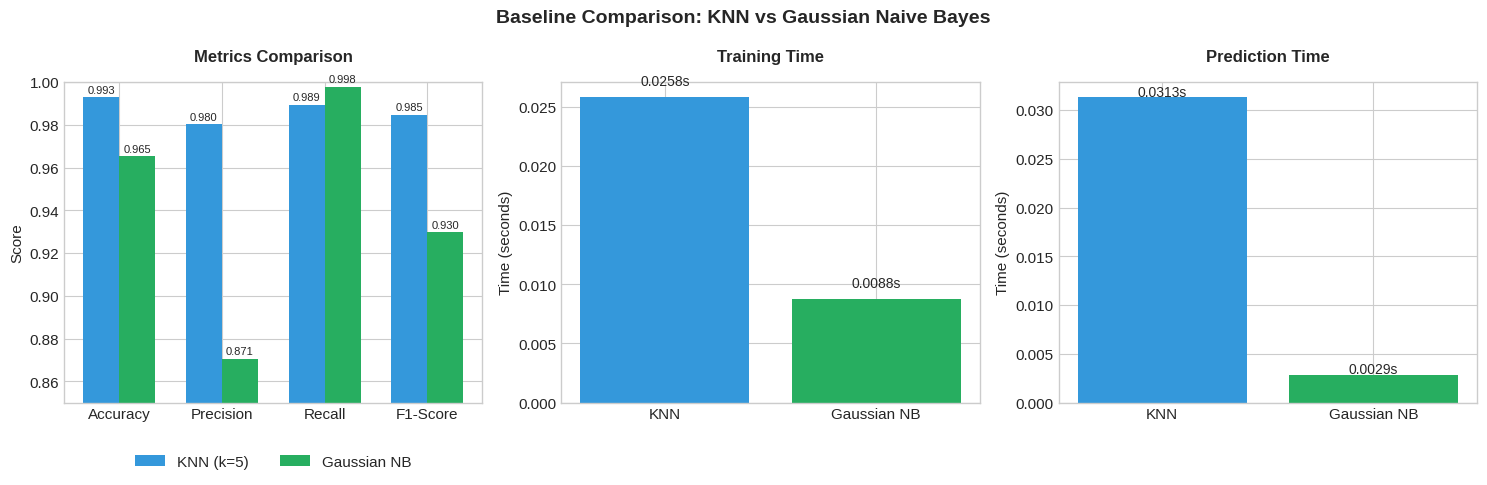

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Bar chart metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
knn_values = [knn_accuracy, knn_precision, knn_recall, knn_f1]
gnb_values = [gnb_accuracy, gnb_precision, gnb_recall, gnb_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, knn_values, width, label='KNN (k=5)', color='#3498db')
bars2 = axes[0].bar(x + width/2, gnb_values, width, label='Gaussian NB', color='#27ae60')

axes[0].set_ylabel('Score')
axes[0].set_title('Metrics Comparison', fontsize=12, fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
axes[0].set_ylim(0.85, 1.0)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

# 2. Bar chart training time
times_train = [knn_train_time, gnb_train_time]
axes[1].bar(['KNN', 'Gaussian NB'], times_train, color=['#3498db', '#27ae60'])
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Training Time', fontsize=12, fontweight='bold', pad=15)
for i, v in enumerate(times_train):
    axes[1].text(i, v + 0.001, f'{v:.4f}s', ha='center', fontsize=10)

# 3. Bar chart prediction time
times_pred = [knn_pred_time, gnb_pred_time]
axes[2].bar(['KNN', 'Gaussian NB'], times_pred, color=['#3498db', '#27ae60'])
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Prediction Time', fontsize=12, fontweight='bold', pad=15)
for i, v in enumerate(times_pred):
    axes[2].text(i, v + 0.0001, f'{v:.4f}s', ha='center', fontsize=10)

plt.suptitle('Baseline Comparison: KNN vs Gaussian Naive Bayes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.7. Simpan Hasil Baseline

In [57]:
results['baseline'] = {
    'knn': {
        'model': 'KNN',
        'params': {'n_neighbors': 5},
        'accuracy': knn_accuracy,
        'precision': knn_precision,
        'recall': knn_recall,
        'f1': knn_f1,
        'train_time': knn_train_time,
        'pred_time': knn_pred_time,
        'confusion_matrix': cm_knn
    },
    'gnb': {
        'model': 'Gaussian Naive Bayes',
        'params': 'default',
        'accuracy': gnb_accuracy,
        'precision': gnb_precision,
        'recall': gnb_recall,
        'f1': gnb_f1,
        'train_time': gnb_train_time,
        'pred_time': gnb_pred_time,
        'confusion_matrix': cm_gnb
    }
}